In [81]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder.master("local[2]").appName("spark_app").enableHiveSupport().getOrCreate()

25/06/26 03:23:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 03:23:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/26 03:23:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/06/26 03:23:10 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/06/26 03:23:10 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
df = spark.read.csv("bankingdata/banking_transaction.csv",inferSchema = True,header = True)

In [4]:
spark.catalog.setCurrentDatabase("varunmdb")

df.printSchema()
df.show()

# Normalize text fields (transaction_type, channel) to lowercase
df_clean = df.withColumn("transaction_type",lower(df["transaction_type"]) ).withColumn("channel",lower(df["channel"]))

# Filter Out Failed Transactions
df_clean = df_clean.filter(df_clean["status"] != "failed")
#df_clean = df_clean.withColumn("txn_day",to_date(df_clean.timestamp) ).withColumn("txn_hour",hour(df_clean.timestamp) )

    
df_clean = df_clean.withColumn("txn_day", dayofmonth(to_date("timestamp"))).withColumn("txn_hour", hour("timestamp")).withColumn("high_value_flag", when(col("amount") > 500, 1).otherwise(0))


df_clean.show()

df.write.mode("overwrite").insertInto('raw_transactions')


root
 |-- transaction_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- amount: double (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- status: string (nullable = true)

+--------------+-----------+-------------------+------+----------------+-------+-------+
|transaction_id|customer_id|          timestamp|amount|transaction_type|channel| status|
+--------------+-----------+-------------------+------+----------------+-------+-------+
|             1|       1082|2025-05-30 22:50:12| 200.2|      withdrawal|    ATM|success|
|             2|       1095|2025-05-26 18:15:58|192.25|         deposit| Branch|success|
|             3|       1004|2025-06-07 21:33:32|184.33|         deposit| Branch|success|
|             4|       1072|2025-06-06 10:26:46|278.95|      withdrawal|    ATM|success|
|             5|       1036|2025-06-05 09:11:09|828.49|         deposit| 

In [5]:
spark.sql("select * from raw_transactions limit 2").show()

+--------------+-----------+-------------------+------+----------------+-------+-------+
|transaction_id|customer_id|         timestamps|amount|transaction_type|channel| status|
+--------------+-----------+-------------------+------+----------------+-------+-------+
|             1|       1082|2025-05-30 22:50:12| 200.2|      withdrawal|    ATM|success|
|             2|       1095|2025-05-26 18:15:58|192.25|         deposit| Branch|success|
+--------------+-----------+-------------------+------+----------------+-------+-------+



In [6]:
df_clean.write.mode("overwrite").insertInto("clean_transactions")

In [8]:
# Register the DataFrame as a temporary view
# df_clean.createOrReplaceTempView("transactions")
# df.createOrReplaceTempView("raw_transactions")

# 1. Top 5 customers by number of transactions
spark.sql("""
SELECT customer_id, COUNT(*) AS num_transactions
FROM clean_transactions
GROUP BY customer_id
ORDER BY num_transactions DESC
LIMIT 5
""").show()

# 2. Customer with the highest total withdrawal amount
spark.sql("""
SELECT customer_id, SUM(amount) AS total_withdrawal
FROM clean_transactions
WHERE transaction_type = 'withdrawal'
GROUP BY customer_id
ORDER BY total_withdrawal DESC
LIMIT 1
""").show()

# 3. Monthly transaction volume per customer
spark.sql("""
SELECT customer_id, DATE_FORMAT(timestamps, 'yyyy-MM') AS month, COUNT(*) AS txn_count
FROM clean_transactions
GROUP BY customer_id, month
ORDER BY customer_id, month
""").show()

# 4. Average transaction amount by channel
spark.sql("""
SELECT channel, AVG(amount) AS avg_amount
FROM clean_transactions
GROUP BY channel
""").show()

# 5. Success rate of transactions by channel
spark.sql("""
SELECT
  channel,
  ROUND(SUM(CASE WHEN status = 'success' THEN 1 ELSE 0 END) / COUNT(*), 2) AS success_rate
FROM clean_transactions
GROUP BY channel
""").show()

# 6. Hourly transaction trend (peak hours)
spark.sql("""
SELECT txn_hour, COUNT(*) AS txn_count
FROM clean_transactions
GROUP BY txn_hour
ORDER BY txn_count DESC
""").show()

# 7. Day-wise total transaction volume and amount
spark.sql("""
SELECT txn_day, COUNT(*) AS txn_count, SUM(amount) AS total_amount
FROM clean_transactions
GROUP BY txn_day
ORDER BY txn_day
""").show()

# 8. Number of high-value transactions (> ₹500) per customer per day
spark.sql("""
SELECT customer_id, txn_day, COUNT(*) AS high_value_txn_count
FROM clean_transactions
WHERE high_value_flag = 1
GROUP BY customer_id, txn_day
ORDER BY customer_id, txn_day
""").show()

+-----------+----------------+
|customer_id|num_transactions|
+-----------+----------------+
|       1032|              42|
|       1014|              38|
|       1041|              38|
|       1084|              37|
|       1018|              37|
+-----------+----------------+



+-----------+------------------+
|customer_id|  total_withdrawal|
+-----------+------------------+
|       1032|13811.570000000002|
+-----------+------------------+



+-----------+-------+---------+
|customer_id|  month|txn_count|
+-----------+-------+---------+
|       1001|2025-05|        4|
|       1001|2025-06|       17|
|       1002|2025-05|        5|
|       1002|2025-06|       18|
|       1003|2025-05|        3|
|       1003|2025-06|       20|
|       1004|2025-05|        3|
|       1004|2025-06|       29|
|       1005|2025-05|        5|
|       1005|2025-06|       18|
|       1006|2025-05|       12|
|       1006|2025-06|       21|
|       1007|2025-05|        4|
|       1007|2025-06|       14|
|       1008|2025-05|        6|
|       1008|2025-06|       17|
|       1009|2025-05|        6|
|       1009|2025-06|       17|
|       1010|2025-05|        7|
|       1010|2025-06|       25|
+-----------+-------+---------+
only showing top 20 rows

+-------+-----------------+
|channel|       avg_amount|
+-------+-----------------+
| online|550.9932276995308|
|    atm|543.2210638297872|
| branch|563.8054493742886|
+-------+-----------------+

+-------+

+--------+---------+
|txn_hour|txn_count|
+--------+---------+
|       7|      123|
|      19|      123|
|      11|      121|
|       0|      119|
|      22|      119|
|       1|      118|
|       2|      118|
|      23|      116|
|      13|      115|
|      10|      113|
|      12|      110|
|      17|      109|
|       9|      108|
|       5|      108|
|      21|      105|
|       6|      104|
|       8|      102|
|      18|      102|
|      20|      101|
|      14|      101|
+--------+---------+
only showing top 20 rows



+-------+---------+------------------+
|txn_day|txn_count|      total_amount|
+-------+---------+------------------+
|      1|       88|48719.049999999996|
|      2|       75|39444.049999999996|
|      3|       78|43144.490000000005|
|      4|       69|35842.829999999994|
|      5|       87| 47592.81000000001|
|      6|      102|59603.519999999975|
|      7|       87| 45472.08000000001|
|      8|       94|53767.769999999975|
|      9|       97| 49049.62999999999|
|     10|       92|47463.419999999984|
|     11|       78| 44055.86000000001|
|     12|       99|          56518.86|
|     13|       83| 50373.60999999998|
|     14|       94|          54303.43|
|     15|       88|          51513.83|
|     16|      101|55754.419999999984|
|     17|       90| 47554.04000000001|
|     18|       78| 44862.31000000001|
|     19|       75| 42361.97000000001|
|     20|       91|45290.139999999985|
+-------+---------+------------------+
only showing top 20 rows



+-----------+-------+--------------------+
|customer_id|txn_day|high_value_txn_count|
+-----------+-------+--------------------+
|       1001|      3|                   1|
|       1001|      6|                   1|
|       1001|     10|                   1|
|       1001|     11|                   1|
|       1001|     12|                   1|
|       1001|     15|                   2|
|       1001|     16|                   2|
|       1001|     19|                   1|
|       1001|     21|                   1|
|       1001|     22|                   1|
|       1001|     29|                   2|
|       1001|     30|                   1|
|       1002|      1|                   2|
|       1002|      3|                   1|
|       1002|      5|                   1|
|       1002|      6|                   1|
|       1002|      7|                   1|
|       1002|      8|                   1|
|       1002|      9|                   1|
|       1002|     13|                   1|
+----------

In [9]:
# 9. Customers with more than 3 failed transactions in a day
spark.sql('select customer_id, dayofmonth(timestamps) as days, count(status) as cnt_status from raw_transactions where status="failed" group by days, customer_id having count(status)>3 order by cnt_status desc').show()

+-----------+----+----------+
|customer_id|days|cnt_status|
+-----------+----+----------+
+-----------+----+----------+



In [22]:
#Customers who used all three channels (ATM, Online, Branch) in the last 7 days
sorted_timestamp = spark.sql('select customer_id, channel, timestamps from raw_transactions order by timestamps desc')
sorted_date = sorted_timestamp.withColumn("dates", to_date(sorted_timestamp.timestamps))
last_7 = sorted_timestamp.filter(sorted_timestamp.timestamps>=date_sub(sorted_timestamp.timestamps, 7))
customers_all = last_7.select(["customer_id", "channel"]).filter((last_7.channel=='ATM')&(last_7.channel=='Branch')&(last_7.channel=='Online'))
customers_all.show()

+-----------+-------+
|customer_id|channel|
+-----------+-------+
+-----------+-------+



In [23]:
channel_trans = spark.sql("""
SELECT channel, AVG(amount) AS avg_amount
FROM clean_transactions
GROUP BY channel
""").toPandas()

In [71]:
import matplotlib.pyplot as plt

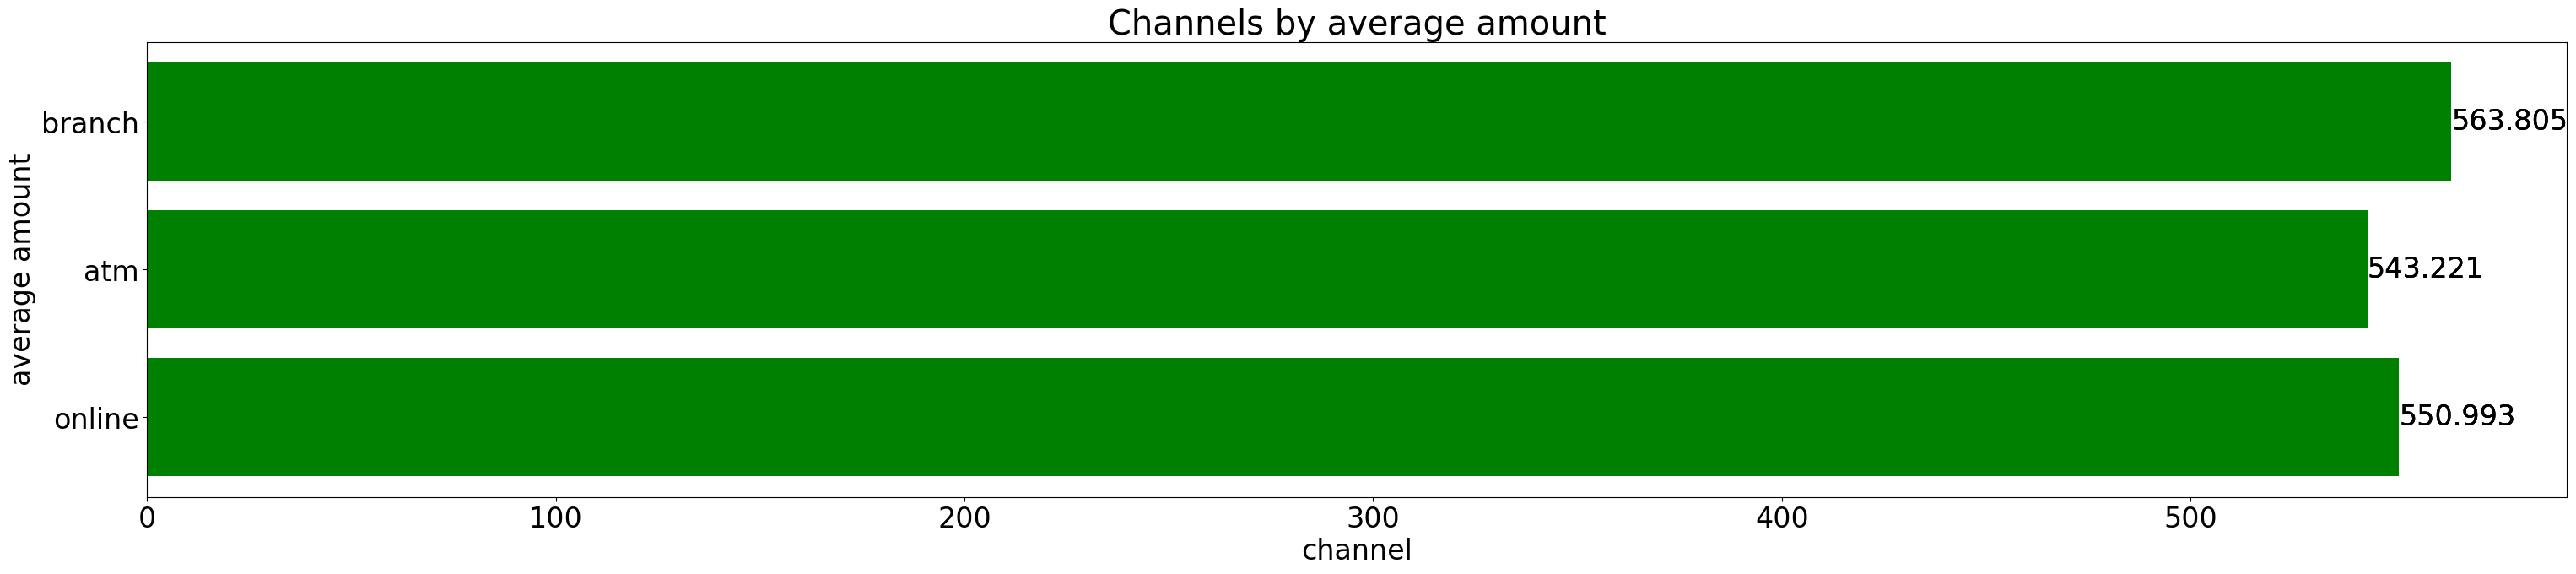

In [85]:
fig = plt.figure(figsize=(37,7))
ax = fig.add_subplot()
plt.rcParams.update({'font.size': 24})


for x in channel_trans.avg_amount:
    p = ax.barh(channel_trans.channel, channel_trans.avg_amount, color="green")
    ax.bar_label(p, label_type="edge")
    
ax.set_ylabel('average amount')
ax.set_xlabel('channel')
ax.set_title('Channels by average amount')
plt.show()
fig.savefig('images/2nd.svg', format='svg', dpi=100)

In [26]:
time_id_mon = spark.sql("""
SELECT DATE_FORMAT(timestamps, 'yyyy-MM') AS month, COUNT(*) AS txn_count
FROM clean_transactions
GROUP BY month
ORDER BY month
""").toPandas()

In [27]:
time_id_mon

,month,txn_count
0,2025-05,559
1,2025-06,2065


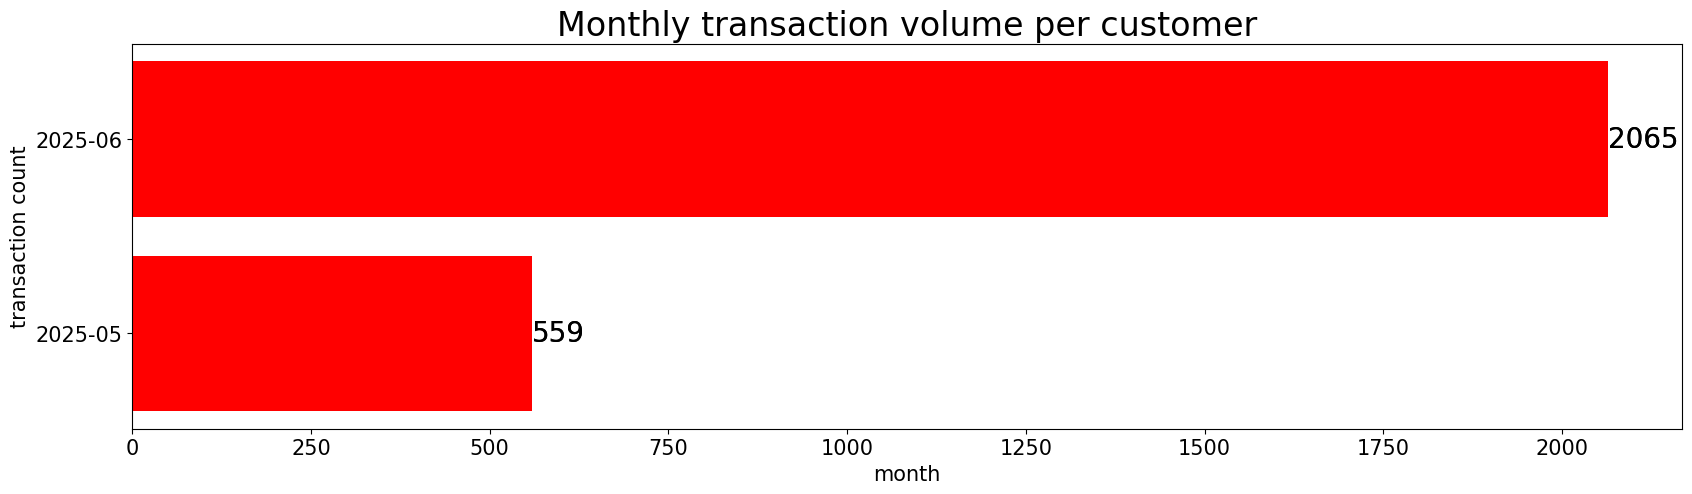

In [82]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
plt.rcParams.update({'font.size': 20})

for x in time_id_mon.txn_count:
    p = ax.barh(time_id_mon.month, time_id_mon.txn_count, color="red")
    ax.bar_label(p, label_type="edge")
    
ax.set_ylabel('transaction count')
ax.set_xlabel('month')
ax.set_title('Monthly transaction volume per customer')
plt.show()
fig.savefig('images/3rd.svg', format='svg', dpi=100)

In [29]:
txn_hour_count = spark.sql("""
SELECT txn_hour, COUNT(*) AS txn_count
FROM clean_transactions
GROUP BY txn_hour order by txn_hour
""").toPandas()

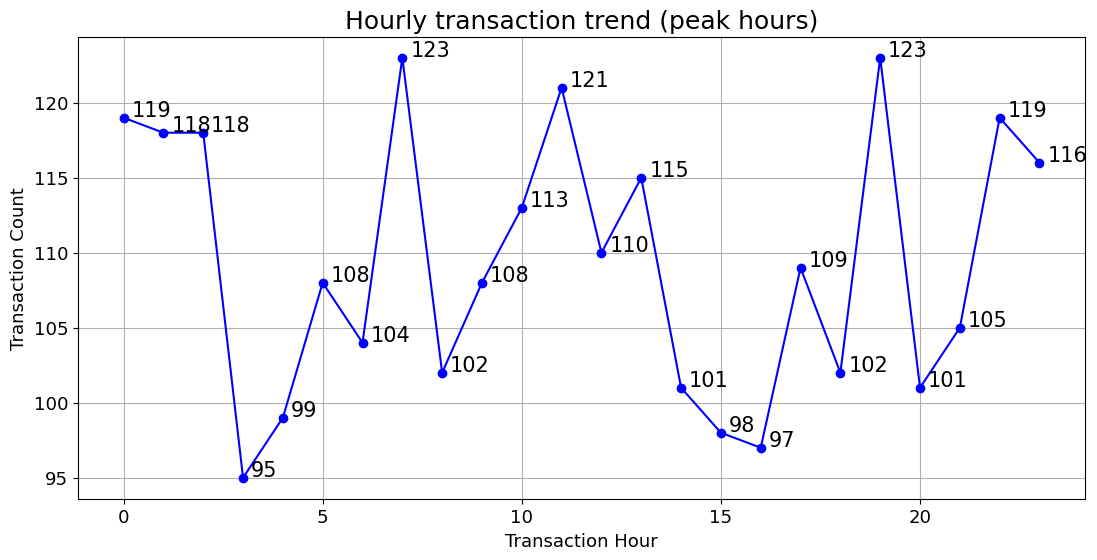

In [79]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
plt.rcParams.update({'font.size': 15})

ax.plot(txn_hour_count.txn_hour, txn_hour_count.txn_count,"blue", marker='o')

for x,y in zip(txn_hour_count.txn_hour, txn_hour_count.txn_count):
    plt.text(x+0.2,y+0.1,y)

ax.set_xlabel("Transaction Hour")
ax.set_ylabel("Transaction Count")
ax.set_title("Hourly transaction trend (peak hours)")
ax.grid()
plt.show()
fig.savefig('images/6th.svg', format='svg', dpi=100)

In [31]:
txn_day_count = spark.sql("""
SELECT txn_day, COUNT(*) AS txn_count
FROM clean_transactions
GROUP BY txn_day
ORDER BY txn_day
""").toPandas()

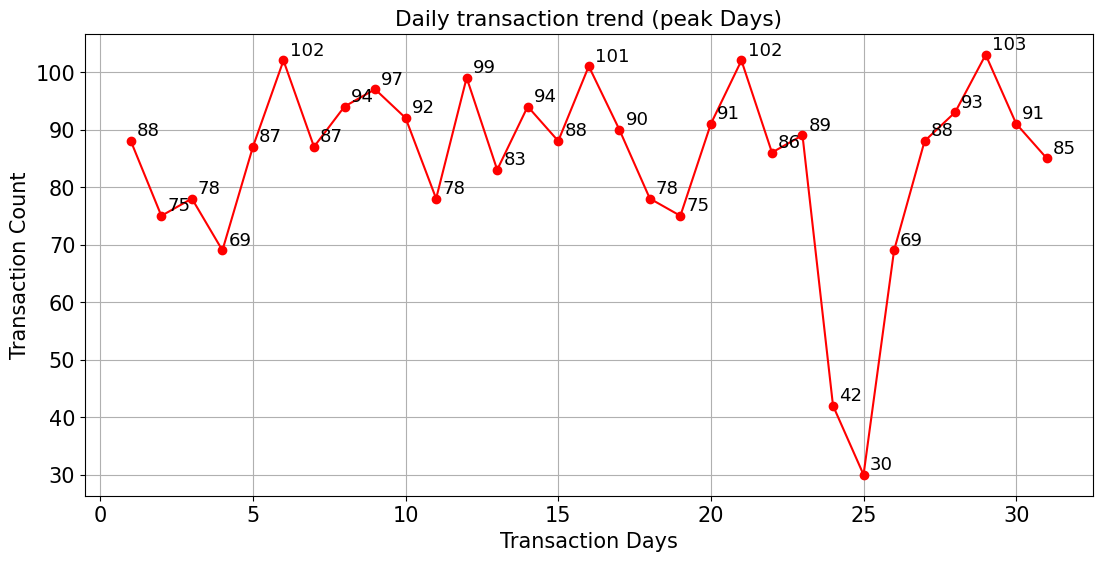

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
plt.rcParams.update({'font.size': 13})

ax.plot(txn_day_count.txn_day, txn_day_count.txn_count,"red", marker='o')

for x,y in zip(txn_day_count.txn_day, txn_day_count.txn_count):
    plt.text(x+0.2,y+0.9,y)

ax.set_xlabel("Transaction Days")
ax.set_ylabel("Transaction Count")
ax.set_title("Daily transaction trend (peak Days)")
ax.grid()
plt.show()
fig.savefig('images/5th.svg', format='svg', dpi=100)

In [33]:
txn_day_amount = spark.sql("""
SELECT txn_day, SUM(amount) AS total_amount
FROM clean_transactions
GROUP BY txn_day
ORDER BY txn_day
""").toPandas()

In [34]:
txn_day_amount

,txn_day,total_amount
0,1,48719.05
1,2,39444.05
2,3,43144.49
3,4,35842.83
4,5,47592.81
5,6,59603.52
6,7,45472.08
7,8,53767.77
8,9,49049.63
9,10,47463.42


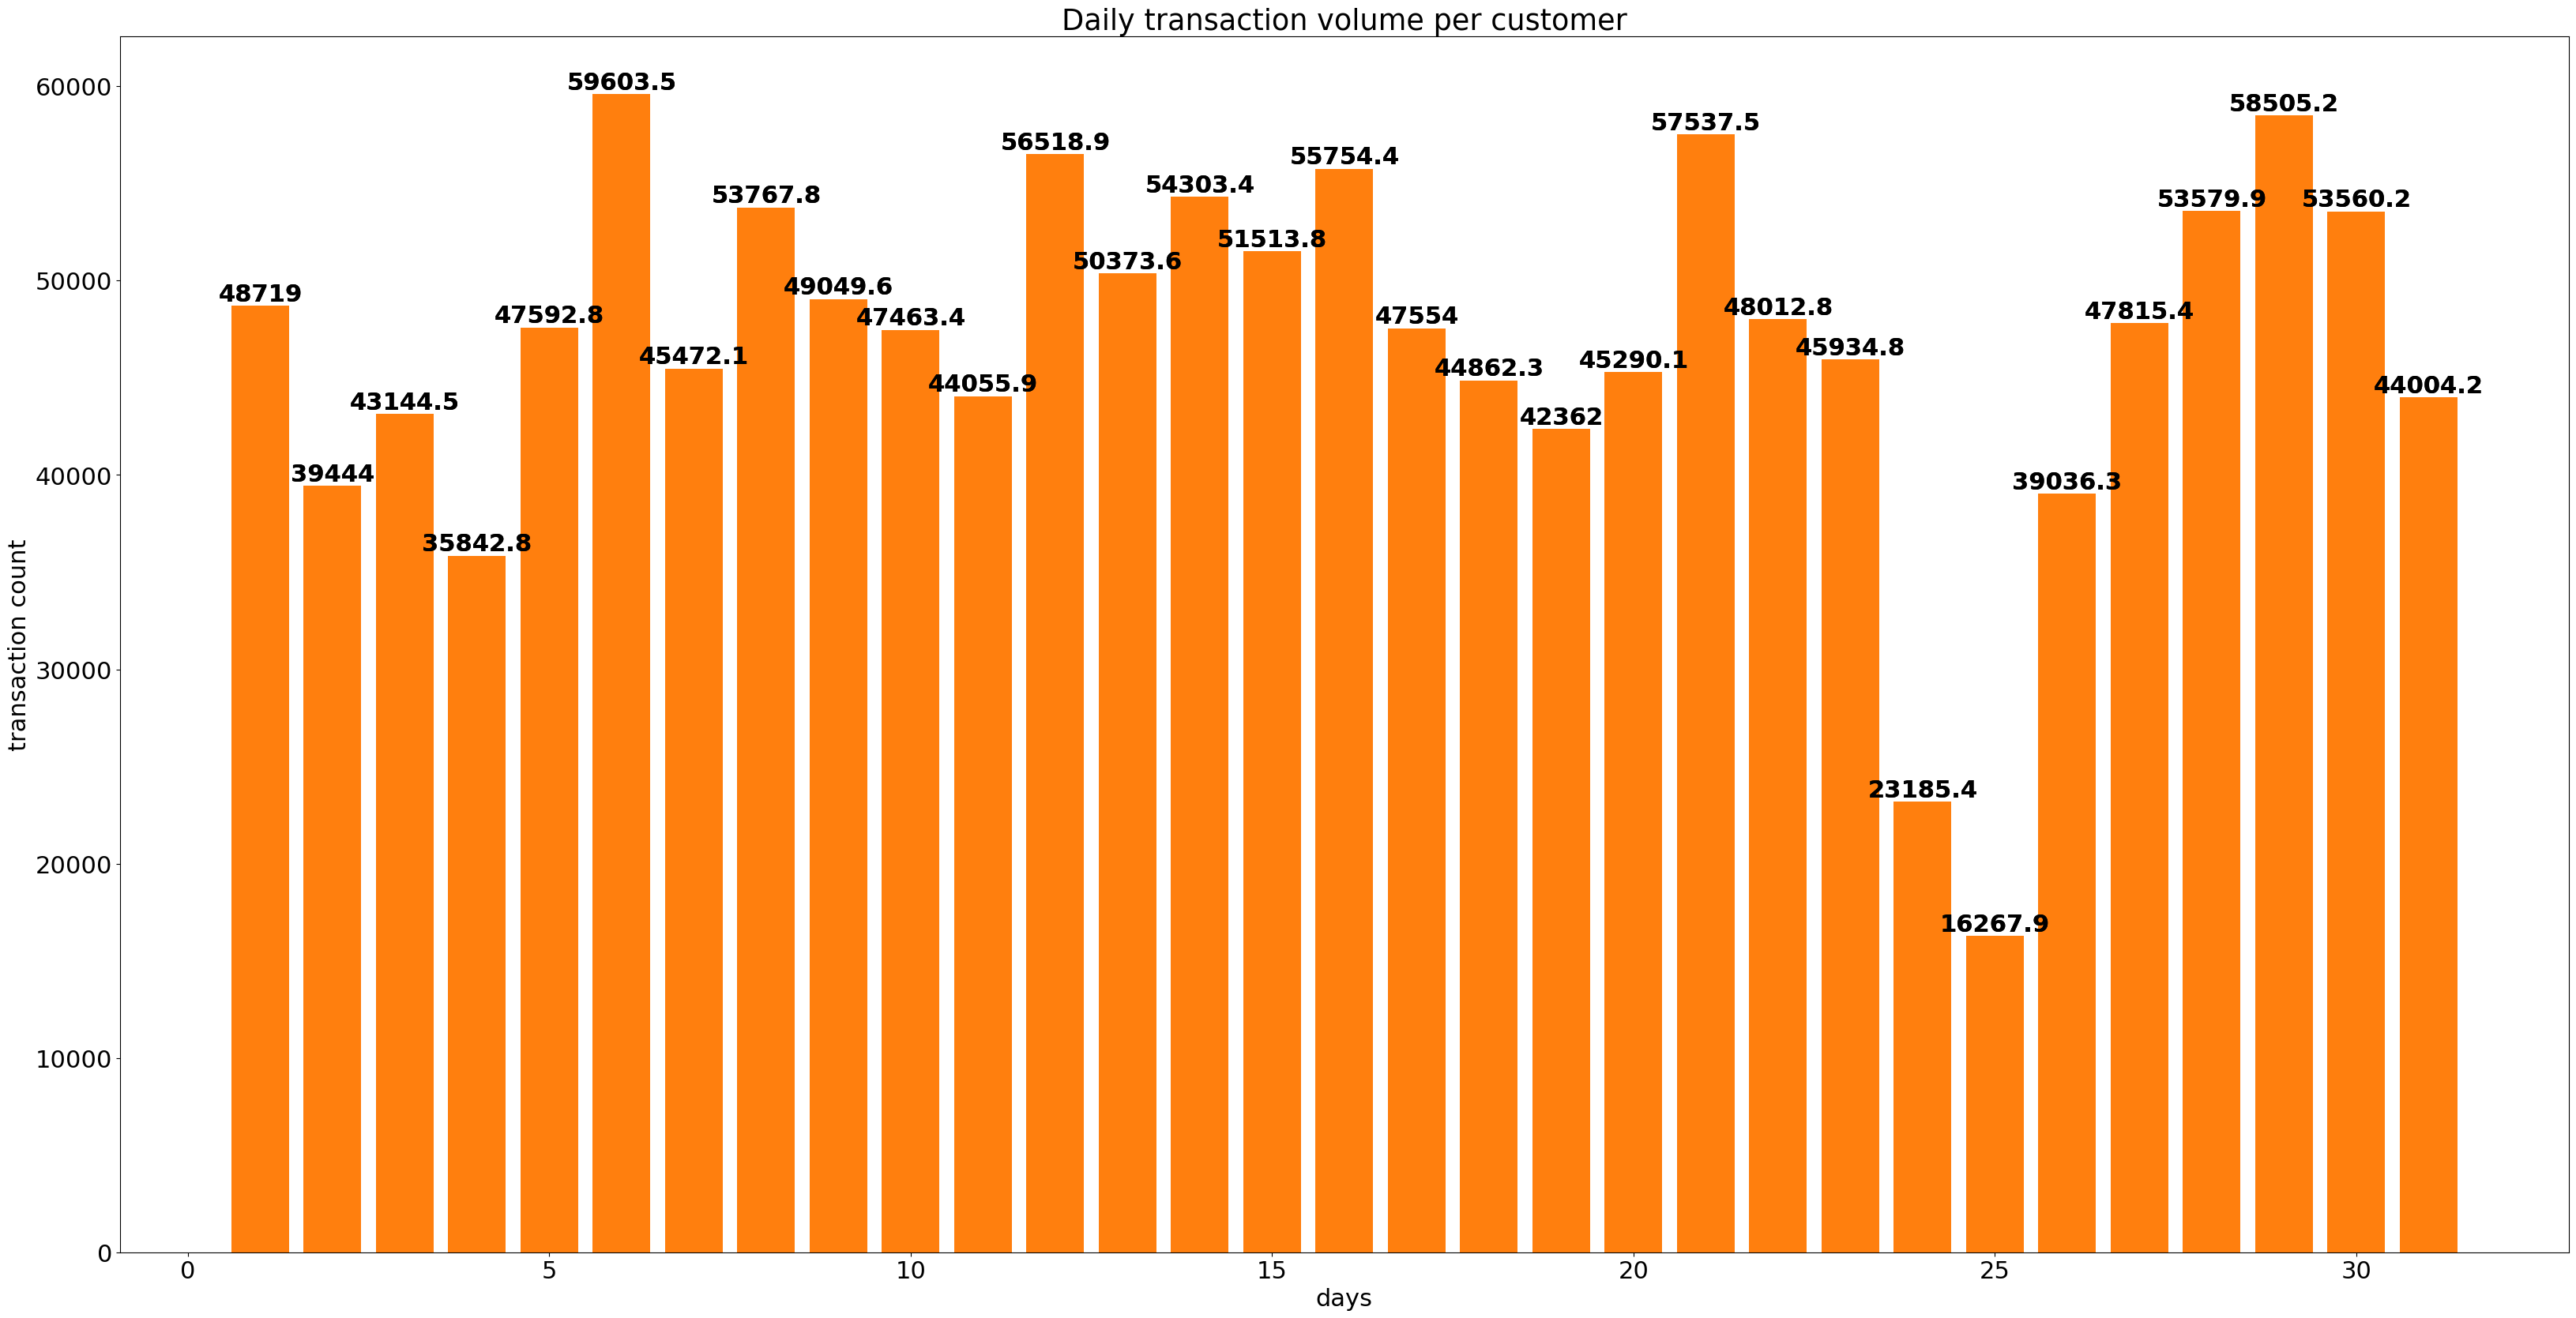

In [69]:
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot()
plt.rcParams.update({'font.size': 22})

for x in txn_day_amount:
    p = ax.bar(txn_day_amount.txn_day, txn_day_amount.total_amount)
    ax.bar_label(p, label_type="edge", fontweight="bold")
    
ax.set_ylabel('transaction count')
ax.set_xlabel('days')
ax.set_title('Daily transaction volume per customer')
plt.show()
fig.savefig('images/4th.svg', format='svg', dpi=100)

In [40]:
topt_cust_trans = spark.sql("""
SELECT customer_id, COUNT(*) AS num_transactions
FROM clean_transactions
GROUP BY customer_id
ORDER BY num_transactions DESC
LIMIT 5
""").toPandas()

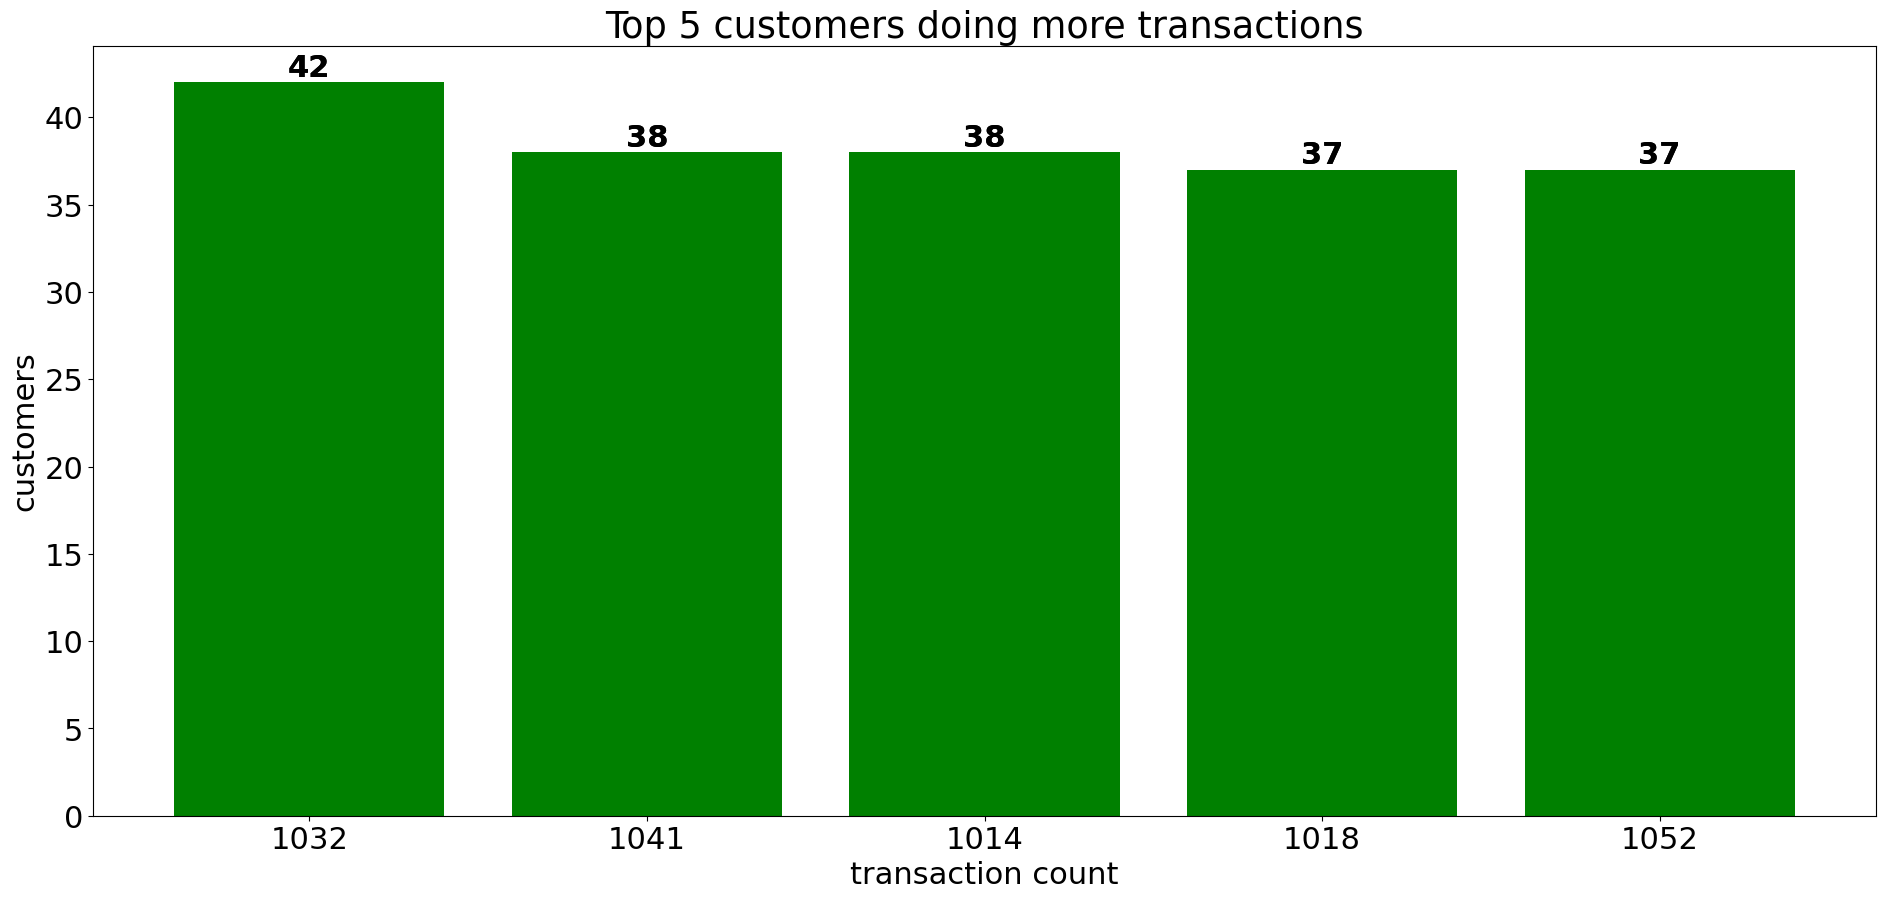

In [62]:
fig = plt.figure(figsize=(23,10))
ax = fig.add_subplot()
plt.rcParams.update({'font.size': 22})

for x in topt_cust_trans:
    p = ax.bar(topt_cust_trans.customer_id, topt_cust_trans.num_transactions, color="green")
    ax.bar_label(p, label_type="edge", fontweight="bold")
    
ax.set_ylabel('customers')
ax.set_xlabel('transaction count')
ax.set_title('Top 5 customers doing more transactions')
plt.show()
fig.savefig('images/1st.svg', format='svg', dpi=100)

In [80]:
from datetime import datetime

In [ ]:
dt = datetime.isoformat(timespec)